# Problem 1

This is a complete simulation transport example. Each aspect of the simulation process is kept to a minimum:
- We use an orthogonal 2D grid;
- We introduce the concept of domain decomposition ("partitioning");
- The domain is homogeneous (single material, uniform isotropic external source), vacuum boundary conditions apply;
- The cross sections are given in a text file (with our OpenSn format); we use only one energy group in this example;
- The angular quadrature (discretization in angle) is introduced;
- The Linear Boltzmann Solver (LBS) options are keep to a minimum.

In [1]:
import os
import sys

## Using this Notebook
Before running this example, make sure that the **Python module of OpenSn** was installed.

### Converting and Running this Notebook from the Terminal
To run this notebook from the terminal, simply type:

`jupyter nbconvert --to python --execute problem_one.ipynb`.

To run this notebook in parallel (for example, using 4 processes), simply type:

`mpiexec -n 4 jupyter nbconvert --to python --execute problem_1.ipynb`.

In [2]:
from mpi4py import MPI
size = MPI.COMM_WORLD.size
rank = MPI.COMM_WORLD.rank

if rank == 0:
    print(f"Running the first LBS example with {size} MPI processors.")

Running the first LBS example with 1 MPI processors.


## Import Requirements

Import required classes and functions from the Python interface of OpenSn. Make sure that the path
to PyOpenSn is appended to Python's PATH.

In [3]:
# assuming that the execute dir is the notebook dir
# this line is not necessary when PyOpenSn is installed using pip
# sys.path.append("../../../..")

from pyopensn.mesh import FromFileMeshGenerator, PETScGraphPartitioner
from pyopensn.xs import MultiGroupXS
from pyopensn.source import VolumetricSource
from pyopensn.aquad import GLCProductQuadrature3DXYZ
from pyopensn.solver import DiscreteOrdinatesProblem, SteadyStateSolver, DiscreteOrdinatesCurvilinearProblem
from pyopensn.diffusion import DFEMDiffusionSolver
from pyopensn.fieldfunc import FieldFunctionInterpolationVolume, FieldFunctionGridBased
from pyopensn.context import UseColor, Finalize
from pyopensn.logvol import SphereLogicalVolume, BooleanLogicalVolume, RPPLogicalVolume
from pyopensn.math import Vector3, ScalarSpatialMaterialFunction
import numpy as np
import math

OpenSn version 0.0.1
2025-05-10 18:03:52 Running OpenSn with 1 processes.



In [4]:
import matplotlib.pyplot as plt

##### Disable colorized output.

In [5]:
UseColor(False)

### Orthogonal Mesh Generation
We use the `OrthogonalMeshGenerator` and pass the list of nodes per dimension. Here, we pass 3 times the same list of
nodes to create a 3D geometry with square cells. Thus, we create a square domain, of side length 2, with a vertex on the origin (0,0), in the positive-positive-positive quadrant.

We also partition the 3D mesh into $2 \times 2$ subdomains using `KBAGraphPartitioner`. Since we want the split the x-axis in 2,
we give only 1 value in the xcuts array ($x=0$). Likewise for ycuts ($y=0$) and zcuts ($z=0$). The assignment to a partition is done based on where the
cell center is located with respect to the various xcuts, ycuts, and zcuts (in the code, a fuzzy logic is applied to avoid arithmetic issues).

In [6]:
meshgen = FromFileMeshGenerator(
    filename="./vtk_meshes/three_spheres.msh",
    partitioner=PETScGraphPartitioner(type='parmetis'),
)
grid = meshgen.Execute()

# Export
grid.ExportToPVTU("Read_3D_gmsh")

[0]  FromFileMeshGenerator: Generating UnpartitionedMesh
[0]  Making unpartitioned mesh from Gmsh file ./vtk_meshes/three_spheres.msh (format v2.2)
[0]  Mesh identified as 3D.
[0]  Done checking cell-center-to-face orientations
[0]  00:00:02.5 Establishing cell connectivity.
[0]  00:00:02.5 Vertex cell subscriptions complete.
[0]  00:00:02.6 Surpassing cell 2147 of 21466 (10%)
[0]  00:00:02.7 Surpassing cell 4294 of 21466 (20%)
[0]  00:00:02.7 Surpassing cell 6440 of 21466 (30%)
[0]  00:00:02.7 Surpassing cell 8587 of 21466 (40%)
[0]  00:00:02.8 Surpassing cell 10733 of 21466 (50%)
[0]  00:00:02.8 Surpassing cell 12880 of 21466 (60%)
[0]  00:00:02.8 Surpassing cell 15027 of 21466 (70%)
[0]  00:00:02.9 Surpassing cell 17173 of 21466 (80%)
[0]  00:00:02.9 Surpassing cell 19320 of 21466 (90%)
[0]  00:00:02.9 Surpassing cell 21466 of 21466 (100%)
[0]  00:00:02.9 Establishing cell boundary connectivity.
[0]  00:00:02.9 Done establishing cell connectivity.
[0]  Done processing ./vtk_meshes/t

### Material IDs
When using the in-house `OrthogonalMeshGenerator`, no material IDs are assigned. The user needs to
assign material IDs to all cells. Here, we have a homogeneous domain, so we assign a material ID
with value 0 for each cell in the spatial domain.

## Cross Sections
We create one-group cross sections using a built-in method. 
See the tutorials' section on cross sections for more details on how to load cross sections into OpenSn.

In [7]:
xs_mat = MultiGroupXS()
xs_mat.CreateSimpleOneGroup(sigma_t=1.,c=0.0)
xs_void = MultiGroupXS()
xs_void.CreateSimpleOneGroup(sigma_t=0.,c=0.0)
xs_src = MultiGroupXS()
xs_src.CreateSimpleOneGroup(sigma_t=0.,c=0.0)

[0]  *** WARNING ***  Negative transport cross section found for group 0 in call to ComputeDiffusionParameters. sigma_t=0 sigma_1=0. Setting sigma_1=0, sigma_tr=sigma_t for this group.
[0]  *** WARNING ***  Negative transport cross section found for group 0 in call to ComputeDiffusionParameters. sigma_t=0 sigma_1=0. Setting sigma_1=0, sigma_tr=sigma_t for this group.


## Volumetric Source
We create a volumetric multigroup source which will be assigned to cells with given block IDs.
Volumetric sources are assigned to the solver via the `options` parameter in the LBS block (see below).

In [13]:
src_vol = SphereLogicalVolume(r=0.5)

In [8]:
mg_src = VolumetricSource(block_ids=[2], group_strength=[1.])
# mg_src = VolumetricSource(logical_volume=src_vol, group_strength=[1.])

## Angular Quadrature
We create a product Gauss-Legendre-Chebyshev angular quadrature and pass the total number of polar cosines
(here `npolar = 4`) and the number of azimuthal subdivisions in **four quadrants** (`nazimu = 4`).
This creates a 2D angular quadrature for XY geometry.

In [9]:
nazimu = 4
npolar = 2
pquad = GLCProductQuadrature3DXYZ(npolar, nazimu)

## Linear Boltzmann Solver
### Options for the Linear Boltzmann Problem (LBS)
In the LBS block, we provide
+ the number of energy groups,
+ the groupsets (with 0-indexing), the handle for the angular quadrature, the angle aggregation, the solver type,
tolerances, and other solver options.

In [12]:
phys = DiscreteOrdinatesProblem(
    mesh=grid,
    num_groups=1,
    groupsets=[
        {
            "groups_from_to": (0, 0),
            "angular_quadrature": pquad,
            "angle_aggregation_type": "single",
            "angle_aggregation_num_subsets": 1,
            "inner_linear_method": "petsc_gmres",
            "l_abs_tol": 1.0e-6,
            "l_max_its": 300,
            "gmres_restart_interval": 30
        }
    ],
    options={
        "scattering_order": 0,
        "volumetric_sources": [mg_src],
        "boundary_conditions": [
            {"name":"xmin", "type":"vacuum"},
            {"name":"xmax", "type":"vacuum"},
            {"name":"ymin", "type":"vacuum"},
            {"name":"ymax", "type":"vacuum"},
            {"name":"zmin", "type":"vacuum"},
            {"name":"zmax", "type":"vacuum"}
        ]
    },
    xs_map=[
        {
            "block_ids": [1,3],
            "xs": xs_void
        },
        {
            "block_ids": [2],
            "xs": xs_src
        }
    ]
)

In [13]:
ss_solver = SteadyStateSolver(lbs_problem=phys)
ss_solver.Initialize()
ss_solver.Execute()

[0]  
[0]  Initializing LBS SteadyStateSolver with name: LBSDiscreteOrdinatesProblem
[0]  
[0]  Scattering order    : 0
[0]  Number of Groups    : 1
[0]  Number of Group sets: 1
[0]  
[0]  ***** Groupset 0 *****
[0]  Groups:
[0]      0 
[0]  
[0]  Initializing spatial discretization.
[0]  Computing unit integrals.
[0]  Ghost cell unit cell-matrix ratio: 0%
[0]  Cell matrices computed.
[0]  Initializing parallel arrays. G=1 M=1
[0]  Done with parallel arrays.
[0]  Volumetric source #0 has 5674 total subscribing cells.
[0]  00:03:14.4 Initializing sweep datastructures.
[0]  00:03:16.0 Done initializing sweep datastructures.
[0]  00:03:16.0 Initialized angle aggregation.
[0]  Initializing WGS and AGS solvers
[0]  
[0]  
[0]  ********** Solving groupset 0 with PETSC_GMRES.
[0]  
[0]  Quadrature number of angles: 8
[0]  Groups 0 0
[0]  
[0]  Total number of angular unknowns: 686912
[0]  Number of lagged angular unknowns: 0(0%)
[0]  00:03:16.0 Computing b
[0]  00:03:16.4 WGS groups [0-0] Ite

In [14]:
fflist = phys.GetFieldFunctions()

vtk_basename = "problem_two"
FieldFunctionGridBased.ExportMultipleToVTK(
    [fflist[0]],  # export only the flux of group 0 (first []), moment 0 (second [])
    vtk_basename
)

[0]  Exporting field functions to VTK with file base "problem_two"
[0]  Done exporting field functions to VTK.


In [15]:
def average_vol(vol0, r1, r2):
    ffvol = FieldFunctionInterpolationVolume()
    ffvol.SetOperationType("avg")
    ffvol.SetLogicalVolume(vol0)
    ffvol.AddFieldFunction(fflist[0])
    ffvol.Initialize()
    ffvol.Execute()
    avgval = ffvol.GetValue()
    print("Radius: {:.2f} {:.2f} {:.6f}".format(r1, r2, avgval))
    return avgval

def create_vols(N_vols, rmax):
    r_vals = np.linspace(0, rmax, N_vols + 1)
    vols = np.empty(N_vols)
    avgphi = np.zeros(N_vols)
    for i in range(N_vols):
        if i != 0:
            inner_vol = SphereLogicalVolume(r=r_vals[i])
            outer_vol = SphereLogicalVolume(r=r_vals[i + 1])
            vol = BooleanLogicalVolume(parts=[{"op":True,"lv":outer_vol},{"op":False,"lv":inner_vol}])
        else:
            vol = SphereLogicalVolume(r=r_vals[i + 1])
        avgphi[i] = average_vol(vol, r_vals[i], r_vals[i+1])
    return avgphi

In [16]:
n_vols = 10
sim_vals = create_vols(n_vols, 1)

Radius: 0.00 0.10 0.338596
Radius: 0.10 0.20 0.349545
Radius: 0.20 0.30 0.387931
Radius: 0.30 0.40 0.463697
Radius: 0.40 0.50 0.479327
Radius: 0.50 0.60 0.432441
Radius: 0.60 0.70 0.326860
Radius: 0.70 0.80 0.205264
Radius: 0.80 0.90 0.145196
Radius: 0.90 1.00 0.110644


In [17]:
def get_phi(r, q, a, b):
    a2 = a**2
    b2 = b**2
    r2 = r**2
    phi = q*(b+(b2-r2)/(2*r)*math.log((b+r)/(abs(r-b))))-q*(a+(a2-r2)/(2*r)*math.log((a+r)/(abs(r-a))))
    return phi        

In [18]:
q = 0.5
a = 1/3
b = 2/3
r_vals = np.linspace(0.05, 0.95, n_vols)
phi = np.zeros(n_vols)
for i in range(n_vols):
    phi[i] = get_phi(r_vals[i], q, a, b)
    print(r_vals[i], phi[i])

0.05 0.33459328354052764
0.15 0.34546744975652766
0.25 0.3732207206711644
0.35 0.4651100171543332
0.44999999999999996 0.4837516208432012
0.5499999999999999 0.4401951653290374
0.65 0.33925104266213946
0.75 0.19894355805052705
0.85 0.1428819750280989
0.95 0.109376236442571


In [19]:
err = np.zeros(n_vols)
err[:] = 100*abs(phi[:]-sim_vals[:])/phi[:]
print(err)

[1.1963675  1.1803584  3.94142727 0.30370071 0.9145616  1.76162493
 3.65239049 3.17695821 1.61940478 1.15879564]


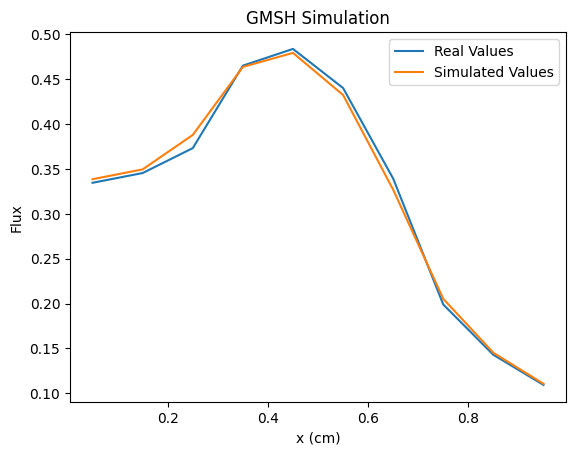

In [20]:
plt.figure(1)
plt.plot(r_vals,phi)
plt.plot(r_vals,sim_vals)
plt.title("GMSH Simulation")
plt.xlabel("x (cm)")
plt.ylabel("Flux") 
plt.legend(["Real Values", "Simulated Values"])
plt.show()

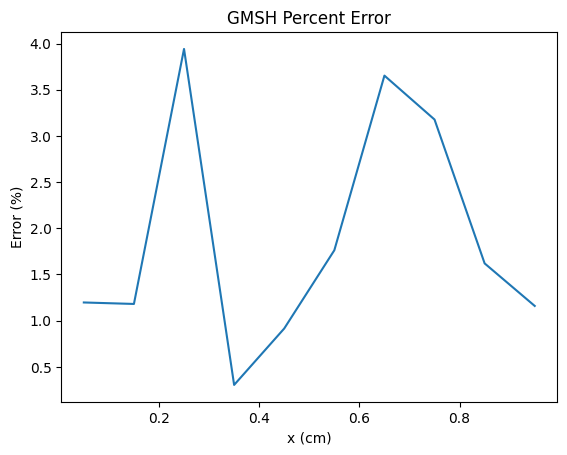

In [21]:
plt.figure(2)
plt.plot(r_vals,err)
plt.title("GMSH Percent Error")
plt.ylabel("Error (%)")
plt.xlabel("x (cm)")
plt.show()

## Finalize (for Jupyter Notebook only)

In Python script mode, PyOpenSn automatically handles environment termination. However, this
automatic finalization does not occur when running in a Jupyter notebook, so explicit finalization
of the environment at the end of the notebook is required. Do not call the finalization in Python
script mode, or in console mode.

Note that PyOpenSn's finalization must be called before MPI's finalization.


In [22]:
from IPython import get_ipython

def finalize_env():
    Finalize()
    MPI.Finalize()

ipython_instance = get_ipython()
if ipython_instance is not None:
    ipython_instance.events.register("post_execute", finalize_env)


Elapsed execution time: 00:07:43.3
2025-05-10 18:10:59 OpenSn finished execution.


## Possible Extensions
1. Change the number of MPI processes;
2. Change the spatial resolution by increasing or decreasing the number of cells;
3. Change the angular resolution by increasing or decreasing the number of polar and azimuthal subdivisions.